In [36]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import os
import scipy
import sys; sys.path.append('/home/marcush/projects/neural_control/analysis_scripts/turnkey')

from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
from config import PATH_DICT; sys.path.append(PATH_DICT['repo'])
from region_select import *
from loaders import load_franklab_new
from utils import calc_loadings
from collections import defaultdict
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold


# New
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from mpi4py import MPI

### Load consolidated decoding dataframe

In [37]:
decoding_glom_path = '/home/marcush/Data/FrankLabData/neural_control_output/decoding_fullarg_frank_lab/decoding_fullarg_frank_lab_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat = pickle.load(f) 

df_decode = pd.DataFrame(dat)

# Get data and perform CCA

# This only works for one session. Could adjust this for multi-sessions...

In [86]:
RELOAD = True
BIN_WIDTH = 25
max_cca_dim_check = 50


fold_splits = np.unique(df_decode['fold_idx'].values)
sessions = np.unique(df_decode['data_file'])
comm = MPI.COMM_WORLD
sessions = np.array_split(sessions, comm.size)[comm.rank]
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))


if RELOAD:

    lags = np.array([0])
    windows = np.array([1])
    reg0 = regions[0]
    reg1 = regions[1]
    results = []

    for session in sessions:
        save_path_cca_corrs = '/home/marcush/projects/neural_control/analysis_scripts/FrankLabAnalysis/CCA_Results/CCAModel_%s.pkl' % session

        lArgs = {'bin_width': BIN_WIDTH, 'region': reg0, 'spike_threshold': 0, 'speed_threshold': False, 'trialize': False}
        dat = load_franklab_new(get_data_path(reg0), **lArgs)
        X = dat['spike_rates']


        lArgs = {'bin_width': BIN_WIDTH, 'region': reg1, 'spike_threshold': 0, 'speed_threshold': False, 'trialize': False}
        dat = load_franklab_new(get_data_path(reg1), **lArgs)
        Y = dat['spike_rates']


        for k, lag in enumerate(lags):
            for w, window in enumerate(windows):
                for fold_idx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=len(fold_splits)).split(X)):
                
                    x = X[train_idxs]
                    y = Y[train_idxs]

                    # Apply window and lag relative to each other
                    if lag != 0:
                        x = x[:-lag, :]
                        y = x[lag:, :]

                    if window > 1:
                        x = form_lag_matrix(x, window)
                        y = form_lag_matrix(y, window)

                    ccamodel = CCA(n_components=min(max_cca_dim_check, min(x.shape[-1], y.shape[-1])))                
                    ccamodel.fit(x, y)
                    X_c, Y_c = ccamodel.transform(x, y)
                    canonical_correlations = [scipy.stats.pearsonr(X_c[:, i], Y_c[:, i])[0] for i in range(max_cca_dim_check)]

                    r = {
                    'dfile': session,
                    'bin_width': BIN_WIDTH,
                    'lag': lag,
                    'win': window,
                    'fold_idx': fold_idx,
                    'ccamodel': ccamodel,
                    'canonical_correlations': canonical_correlations
                    }
                    results.append(r)
                    print(f"Done with fold {fold_idx+1}")

    df_results = pd.DataFrame(results)
    with open(save_path_cca_corrs, 'wb') as f:
        pickle.dump(df_results, f)
else:

    save_path_cca_corrs = '/home/marcush/projects/neural_control/analysis_scripts/FrankLabAnalysis/CCA_Results/CCAModel_%s.pkl' % 'dataset1'
    with open(save_path_cca_corrs, 'rb') as f:
        df_results = pickle.load(f)
    print("Loading previous CCA fit to split data.")

FILTERING SPIKE RATES!
FILTERING SPIKE RATES!
Done with fold 1
Done with fold 2
Done with fold 3
Done with fold 4
Done with fold 5


### Find saturating CCA dimensionality

In [87]:
canonical_correlations = np.array(df_results['canonical_correlations'].to_list())

Text(0.5, 0, 'Dimension')

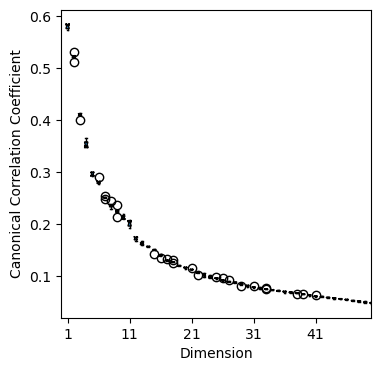

In [88]:
fig, ax = plt.subplots(figsize=(4, 4))

medianprops = dict(linewidth=0)
bplot = ax.boxplot(np.reshape(canonical_correlations, (-1, max_cca_dim_check)), patch_artist=True, medianprops=medianprops, notch=True)
nTicks = 10
ax.set_xticks(np.arange(1, max_cca_dim_check, nTicks))
ax.set_xticklabels(np.arange(1, max_cca_dim_check, nTicks))
ax.set_xlim([0, max_cca_dim_check])
ax.set_ylabel('Canonical Correlation Coefficient')
ax.set_xlabel('Dimension')

# Use BIC to determine optimal CCA dimensionality

In [89]:
# p <= q
def CC_AIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -2 * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

def CC_BIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -np.log(N) * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

In [90]:
nSplits = len(fold_splits)
cc_dim = np.zeros((nSplits, 2))


for split in fold_splits: 

    train_idxs, test_idxs = list(KFold(n_splits=nSplits).split(X))[split]

    x = X[train_idxs]
    y = Y[train_idxs]

    p = min(x.shape[1], y.shape[1])
    q = max(x.shape[1], y.shape[1])

    Ak = CC_AIC(canonical_correlations[split, :], x.shape[0], p, q)
    cc_dim[split, 0] = np.argmin(Ak)
    Ak = CC_BIC(canonical_correlations[split, :], x.shape[0], p, q)    
    cc_dim[split, 1] = np.argmin(Ak)

Text(0, 0.5, 'Dimension')

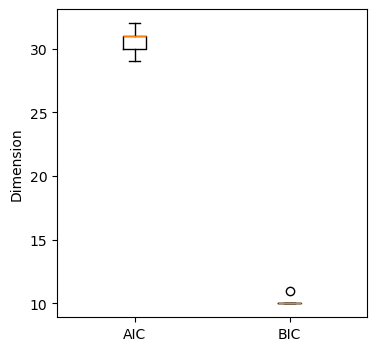

In [91]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(cc_dim + 1)
ax.set_xticklabels(['AIC', 'BIC'])
ax.set_ylabel('Dimension')

In [92]:
print(f"Optimal AIC Dim: {np.median(cc_dim[:,0])}")
print(f"Optimal BIC Dim: {np.median(cc_dim[:,1])}")
print(f"Optimal CCA Dim: {np.mean([np.median(cc_dim[:,0]), np.median(cc_dim[:,1])])}")


Optimal AIC Dim: 30.0
Optimal BIC Dim: 9.0
Optimal CCA Dim: 19.5


### Compute and Save CCA Matrices

In [93]:
manual_CCA_dim = 20 

ccamodel = CCA(n_components=manual_CCA_dim)
ccamodel.fit(X, Y)

cca_save_path = f'/home/marcush/projects/neural_control/analysis_scripts/FrankLabAnalysis/CCA_Results/CCA_{manual_CCA_dim}_dims.pkl'

with open(cca_save_path, 'wb') as file:
    pickle.dump(ccamodel, file)